<a href="https://colab.research.google.com/github/123jyoti614/Sentiment_Analysis_using_LSTM/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

device='cuda' if torch.cuda.is_available() else 'cpu'

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

!pip install tqdm
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def getdata(path):
  df=pd.read_csv(path)
  return df

path='/content/reviews - reviews.csv'
df=getdata(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42,shuffle=True)

x_train=train_df['review']
x_test=test_df['review']
y_train=train_df['sentiment']
y_test=test_df['sentiment']

print(x_train.shape)
print(x_test.shape)

(40000,)
(10000,)


In [ ]:
count_positive=0
count_negative=0

for i in y_train:
  if i == 'positive':
    count_positive+=1
  elif i=='negative':
    count_negative+=1


print("Positive reviews:", count_positive/(count_positive + count_negative)*100, "%")
print("Negative reviews:", count_negative/(count_positive + count_negative)*100, "%")


Positive reviews: 49.902499999999996 %
Negative reviews: 50.0975 %


**Preprocessing**


In [ ]:
#The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
# And the lemmatizer to convert words to simpler forms
lemmatizer = WordNetLemmatizer()

def preprocess(x_set):
    result = []
    for i in x_set:
      # <START>
        # Tokenize the sentence and convert to lowercase
        words = tokenizer.tokenize(i.lower())
        # Remove stopwords
        words = [word for word in words if word not in stop_words]

        # Lemmatize the remaining words
        out = [lemmatizer.lemmatize(word) for word in words]
      # <END>
        result.append(out)
    return result

#Testing the function
test_preprocess = preprocess(["This is an assignment.",'The notebook runs on the cloud.','The cloud, however, is very much on the ground,'])
print(test_preprocess)
assert test_preprocess == [['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]

x_train_preprocessed = preprocess(x_train)
x_test_preprocessed = preprocess(x_test)


[['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]


In [ ]:
def create_vocabulary(x_train_preprocessed):
  '''Creates a dictionary with all unique words in corpus with id'''
  vocabulary = {}
  id = 1
  # <START>
  for s in x_train_preprocessed:
      for word in s:
          if word not in vocabulary:
             vocabulary[word] = id
             id += 1
  # <END>
  return vocabulary

vocabulary = create_vocabulary(x_train_preprocessed)
print(len(vocabulary))

84035


In [ ]:
def convert_to_numerical(x_set):
  converted = []
    # <START>
  for x in x_set:
      numerical_review = []
      for word in x:
      # Check if the word exists in the vocabulary
          if word in vocabulary:
             # Append the corresponding ID of the word to the numerical_review list
             numerical_review.append(vocabulary[word])
          else:
              pass
      converted.append(numerical_review)
    # <END>
  return converted

#Testing your function
vocab_list = list(vocabulary.keys())
print(convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]))
assert convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]) == [[48, 187, 4006]]

[[48, 187, 4006]]


In [ ]:
x_train_numerical = convert_to_numerical(x_train_preprocessed)
x_test_numerical = convert_to_numerical(x_test_preprocessed)

print(len(x_train_numerical))

40000


In [ ]:
def convert_labels(y_set):
  converted=[]
    # <START>
  for i in y_set:
      if i == 'positive':
         converted.append(1)
      elif i == 'negative':
            converted.append(0)
    # <END>
  return converted

assert convert_labels(['positive','negative','positive','positive','negative']) == [1,0,1,1,0]

y_train_numerical = convert_labels(y_train)
y_test_numerical = convert_labels(y_test)

print(len(y_train_numerical))

40000


In [ ]:
lengths = [len(i) for i in x_train_preprocessed]
lengths_sum = sum(lengths)
num_lengths = len(lengths)
avg_length = lengths_sum/num_lengths
max_length = max(lengths)

print("Average length of reviews: ", avg_length)
print("Length of the longest review: ", max_length)

Average length of reviews:  123.5333
Length of the longest review:  1455


In [ ]:
#Padding all the reviews to the maximum length would preserve all our data,
# but at the same time it would be highly inefficient.
#Instead, let's settle on an intermediate value of 150 and pad all shorter reviews to 150.
#As for the longer ones, our model can probably perform sentiment analysis without the entire review, so we'll truncate them to 150 words.

#For this purpose, we shall use a ghost ID of 0 to represent the padding token. This is why we did not give this ID to the first word.
def normalize(x_set, max_length):
    temp = np.zeros((len(x_set), max_length),dtype=int)
    for i, sentence in enumerate(x_set):
        if len(sentence) != 0:
            temp[i, -len(sentence):] = np.array(sentence)[:max_length]
    return temp

max_length = 150

x_train_normalized = normalize(x_train_numerical, max_length)
x_test_normalized = normalize(x_test_numerical, max_length)

In [ ]:
##Now that we are done processing all the reviews, it's time to start building our sentiment analysis model. But first, we'll need to convert our training and testing data into a suitable form.

#This can be done using the TensorDataset class of PyTorch, which creates a dataset containing tensors for input features and labels.

#Since this class takes only NumPy ndarrays as parameters, we'll need to convert y_train_numerical and y_test_numerical into ndarrays.


final_train_data = TensorDataset(torch.from_numpy(x_train_normalized), torch.tensor(y_train_numerical))
final_test_data = TensorDataset(torch.from_numpy(x_test_normalized), torch.tensor(y_test_numerical))


Loading the Data in Batches
Since our dataset is quite large, loading it all at once won't be feasible. A much more efficient way of loading the dataset is to do it in batches. This can be done using PyTorch's DataLoader constructor.

The below cell creates train_batch_loader and test_batch_loader, using the variable batch_size.

In [ ]:
batch_size = 64

train_batch_loader = DataLoader(final_train_data, shuffle=True, batch_size=batch_size)
test_batch_loader = DataLoader(final_test_data, shuffle=True, batch_size=batch_size)

In [ ]:
sample_batch = train_batch_loader
for x, y in sample_batch:
  print("Input size:", x.size())
  print("Input feature: \n", x)
  print("Label: \n", y)
  break

Input size: torch.Size([64, 150])
Input feature: 
 tensor([[ 1928,  1148,   498,  ...,   489,   519, 39730],
        [    0,     0,     0,  ...,  6589,  1317,   633],
        [    0,     0,     0,  ...,  1983,  3521,  4974],
        ...,
        [    0,     0,     0,  ...,   112,   520,  4389],
        [    0,     0,     0,  ...,   293,  2313,  1390],
        [    0,     0,     0,  ...,   238,  2144,   304]])
Label: 
 tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])


Building the Model
Complete the below cell to build the RNN model. This time, we will be using Python classes to define the model. The class will inherit from torch.nn.Module, which is PyTorch's base class for all neural network modules.

This time, the model will have 5 parts:

An Embedding layer that converts the IDs of all the words in the vocabulary, and converts them to embedding vectors of a defined size
Note that this is basically doing the job of the emdedding model from last time
The LSTM layer(s) that will sequentially run through the data.
PyTorch allows you to define multiple continuous LSTM layers with a simpler syntax than having to individually define each one
The Dropout layer. This makes sure our model doesn't overfit the training data. With a predefined probability, it excludes certain nodes from the architecture in each training run.
The Linear layer. This takes the predicted tokens and converts them into a single prediction on whether or not the sentiment is positive or negative.
Of course, the part of making the predicition a probability is done by the Sigmoid layer
The forward function has already been written for you. You are to now define these layers in the RNN object.

For the LSTM layer, note that the current assignment implements a batch first approach.

In [ ]:
class RNN_SA(nn.Module):

    # CLASS CONSTRUCTOR
    def __init__(self, num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.5):
        super(RNN_SA,self).__init__()

        # Initialize the class variables with the values provided as arguments
        self.output_layer_size = output_layer_size
        self.hidden_dim = hidden_layer_size
        self.num_layers = num_layers
        self.vocabulary_size = vocabulary_size

        # <START>
        # Define the embedding layer
        self.embedding = nn.Embedding(vocabulary_size, embedding_layer_size)

        # Define the LSTM unit
        self.lstm = nn.LSTM(input_size=embedding_layer_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)

        # Define the Dropout layer
        self.dropout_layer = nn.Dropout(dropout_probability)

        # Define the linear hidden layer and output sigmoid layer
        self.linear_layer = nn.Linear(hidden_layer_size, output_layer_size)
        self.sigmoid_layer = nn.Sigmoid()
        # <END>

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout_layer(lstm_out)
        out = self.linear_layer(out)
        sig_out = self.sigmoid_layer(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out

In [ ]:
num_layers = 2
vocabulary_size = len(vocabulary) + 1
embedding_layer_size = 64
output_layer_size = 1
hidden_layer_size = 256


model = RNN_SA(num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.3)

print(model)

RNN_SA(
  (embedding): Embedding(84036, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


In [ ]:
MY_NOTEBOOK_DIED_MID_TRAINING = False

if MY_NOTEBOOK_DIED_MID_TRAINING:
  model = torch.load('/content/reviews - reviews.csv')

Training the Model
Now that we have our model, let's begin training it on our training data. The hyperparameters have been defined for you. You might notice that the number of epochs is quite low; this is because each epoch takes a pretty long time to run and a model trained with even 5 epochs would take over an hour to finish training.

Since our model is a binary classifier trained to predict 0 and 1, we can use Binary Cross Entropy loss to measure the loss.

Unlike in the first week's assignment, you will not need to explicitly update the parameters after each run of gradient descent, we have imported an optimizer that takes care of this.

We have also given you a function accuracy, that takes as arguments the predictions generated by the model and the corresponding true values, and returns the accuracy.

Your task is to complete the rest of the cell and train the model.

Again, each epoch could take upto 15 minutes to run, so please be patient!

In [ ]:
learning_rate = 1e-3
num_epochs = 3

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def accuracy(prediction, label):
    prediction = torch.round(prediction.squeeze())
    return torch.sum(prediction == label.squeeze()).item()

min_loss_attained = np.inf    # this variable will contain the minimum value of the loss function attained in any of the epochs.
                              #It is used to discard the results of further epochs if their losses are more than min_loss_attained.

epoch_train_loss,epoch_test_loss = [],[]
epoch_train_acc,epoch_test_acc = [],[]    # These lists will hold the average loss and accuracy values of each epoch



for epoch in range(num_epochs):
  train_losses = 0.0
  train_accuracy = 0.0

  progress_bar = tqdm(total=len(train_batch_loader), desc='Training', leave = True)  # You don't need to worry about this line,
                                                                                          # it's just to display a progress bar that shows the percentage trained

  model.train()

  for inputs, labels in train_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>
    # Don't forget to reset the gradients before beginning!
    optimizer.zero_grad()

    output = model(inputs)

    # compute the loss and implement the back propagation step
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    optimizer.step()


    # <END>

    # Calculating loss and accuracy; we will store the cumulative values and finally use them to compute the average loss and accuracy of the epoch
    train_losses += loss.item()
    acc = accuracy(output,labels)
    train_accuracy += acc

    nn.utils.clip_grad_norm_(model.parameters(), 5) # This line helps avoid the exploding gradient problem

    optimizer.step()

    progress_bar.update(1)

  progress_bar.close()

  # After the training run of each epoch, we will evaluate the performance of our model

  test_losses = 0.0  # Again, this will store cumulative loss
  test_accuracy = 0.0   # and this will store cumulative test accuracy

  model.eval()

  for inputs, labels in test_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>   # Compute the loss
    output = model(inputs)
    test_loss = criterion(output.squeeze(), labels.float())
    # <END>

    test_losses += test_loss.item()

    acc = accuracy(output,labels)
    test_accuracy += acc


  epoch_train_accuracy = train_accuracy/len(train_batch_loader.dataset)
  epoch_test_accuracy = test_accuracy/len(test_batch_loader.dataset)


  avg_train_loss = np.mean(train_losses)
  avg_test_loss = np.mean(test_losses)

  epoch_train_loss.append(avg_train_loss)
  epoch_test_loss.append(avg_test_loss)
  epoch_test_acc.append(epoch_test_accuracy)
  epoch_train_acc.append(epoch_train_accuracy)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {avg_train_loss} test_loss : {avg_test_loss}')
  print(f'train_accuracy : {epoch_train_accuracy*100} test_accuracy : {epoch_test_accuracy*100}')
  if avg_test_loss < min_loss_attained:
    torch.save(model.state_dict(), '/content/reviews - reviews.csv')
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_loss_attained, avg_test_loss))
    min_loss_attained = avg_test_loss
  print(70*'=')

Training: 100%|██████████| 625/625 [15:50<00:00,  1.52s/it]


Epoch 1
train_loss : 423.54612106084824 test_loss : 108.25680094957352
train_accuracy : 55.474999999999994 test_accuracy : 50.79
Validation loss decreased (inf --> 108.256801).  Saving model ...


Training: 100%|██████████| 625/625 [15:37<00:00,  1.50s/it]


Epoch 2
train_loss : 383.9539927840233 test_loss : 70.17027582228184
train_accuracy : 64.51 test_accuracy : 80.43
Validation loss decreased (108.256801 --> 70.170276).  Saving model ...


Training: 100%|██████████| 625/625 [15:46<00:00,  1.51s/it]


Epoch 3
train_loss : 212.82760381698608 test_loss : 55.890971288084984
train_accuracy : 85.7375 test_accuracy : 83.65
Validation loss decreased (70.170276 --> 55.890971).  Saving model ...


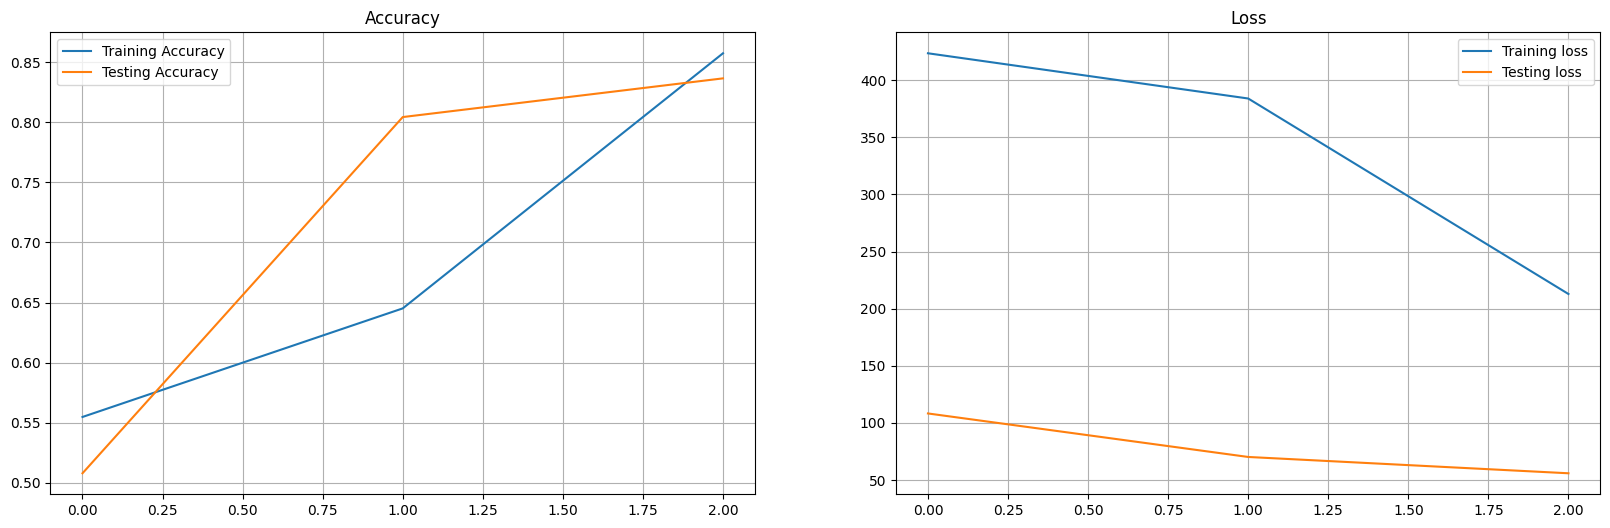

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_acc, label='Training Accuracy')
plt.plot(epoch_test_acc, label='Testing Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Training loss')
plt.plot(epoch_test_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()